In [1]:
import numpy as np
import pandas as pd
import sklearn
import ot
import matplotlib.pyplot as plt


In [2]:
ratings_train = np.load('../datasets/ratings_train.npy')
m,n = ratings_train.shape
data = np.nan_to_num(ratings_train)


In [3]:
def regularization(c,l):
    return l*np.power(np.linalg.norm(c),2)/2

def gradient_ridge_reg(c,c_hat,gamma,l):
    return l*c + (c - c_hat)/gamma



def compute_prox(c_hat, h_prox, x0, iterations = 100, gamma = 0.01, epsilon = 0.01,l = 0.01): #h is the non-differentiable function
    xk = x0
    gk = np.power(np.linalg.norm(xk-c_hat),2)/(2*gamma)
    for _ in range(iterations):
        xk_old = xk
        # compute gradient for differentiable  part of function
        gk_gradient = gradient_ridge_reg(xk,c_hat,gamma,l)
        # take gradient step to reduce g(x)
        xk_gradient = xk - gamma * gk_gradient
        # proximal update to reduce h(x) but stay close to xk_gradient
        xk = xk_gradient #Change if h is constraining function

        if np.linalg.norm(xk - xk_old) < epsilon:
            return xk

    return xk

def current_h(x,gamma):
    return 0


def cost_learning(pi_hat,mu,nu,epsilon,G, D, steps = 100):
    m,n = pi_hat.shape
    alpha = np.random.rand(m,1)
    beta = np.random.rand(n,1)
    u = np.exp(alpha / epsilon)
    v = np.exp(beta / epsilon)
    c = np.random.rand(m,n)
    G = np.linalg.pinv(G)
    D = np.linalg.pinv(D)
    for i in range(steps):
        K = np.exp(-c/epsilon)
        kv = np.dot(K,v).reshape(m,1)
        u = np.divide(mu.reshape(1,m),kv.reshape(1,m)).reshape(m,1)
        ktu = np.dot(K.T,u).reshape(n,1)
        v = np.divide(nu.reshape(1,n),ktu.reshape(1,n)).reshape(n,1)
        K = pi_hat / (np.dot(u,v.T))
        log_k = np.log(K, out=np.zeros_like(K), where=(K!=0))
        A_deomposed = G.T@log_k@D
        c = compute_prox(-epsilon*A_deomposed,current_h,c)
    return epsilon*np.log(u),epsilon*np.log(v),c


def transform_to_integers(matrix):
    # Define the number of intervals and their boundaries
    num_intervals = 10
    min_value = 0.0
    max_value = matrix.max()

    # Calculate the interval width
    interval_width = (max_value - min_value) / num_intervals

    # Map the values to integers between 1 and 10
    transformed_matrix = ((matrix - min_value) / interval_width).clip(0, num_intervals).astype(int) / 2

    return transformed_matrix


def compute_rmse(predictions, test_matrix):
  masked = np.ma.array(test_matrix, mask=np.isnan(test_matrix))
  diff = np.ma.subtract(predictions, masked)
  squared = np.ma.power(diff, 2)
  return np.ma.sqrt(np.ma.mean(squared))


In [4]:
from scipy.spatial.distance import pdist, squareform

user_dist = pdist(data, metric='jaccard')
user_sim_matrix = squareform(user_dist)

movie_dist = pdist(data.T, metric='jaccard')
movie_sim_matrix = squareform(movie_dist)


In [5]:
pi_hat = data / data.sum()

mu_hat = pi_hat.sum(axis = 1)
nu_hat = pi_hat.sum(axis = 0)

G = user_sim_matrix
D = movie_sim_matrix

lambd = 1e-3
ratings_non_zero = np.nan_to_num(ratings_train)
M = ratings_non_zero

Gs = ot.sinkhorn(mu_hat, nu_hat, M, lambd)
print(np.allclose(Gs.sum(axis=1), mu_hat))
print(np.allclose(Gs.sum(axis=0), nu_hat))

epsilon = 0.01

alpha,beta,c = cost_learning(pi_hat,mu_hat,nu_hat,epsilon,G, D, steps=2)
otm = ot.emd(data.sum(axis=1), data.sum(axis=0), c)
otm_scores = transform_to_integers(otm_scores)
compute_rmse(otm_scores, ratings_train)


True
True


3.6555282643655507

In [14]:
otm = ot.emd(data.sum(axis=1), data.sum(axis=0), c)
otm_scores = transform_to_integers(otm)
compute_rmse(otm_scores, ratings_train)


3.6555282643655507

<BarContainer object of 301 artists>

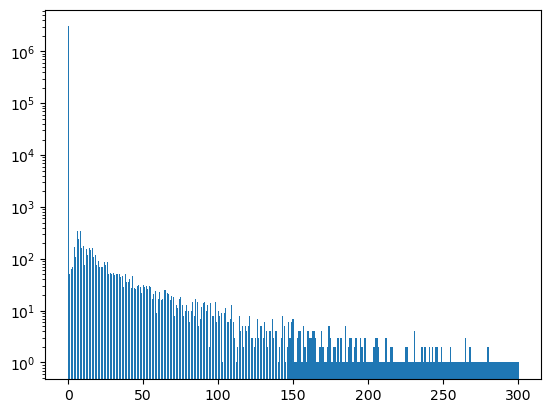

In [27]:
uniques, counts = np.unique(otm, return_counts=True)
fig, ax = plt.subplots()
ax.set_yscale('log')
plt.bar(range(len(uniques)), counts)


In [12]:
c*1000


array([[-7.97695394e+00, -2.10188601e+00,  1.07770576e-01, ...,
        -1.35815229e-01,  3.20606947e-02, -2.14741468e-01],
       [ 1.76985947e+00,  1.48055046e+00,  1.20732131e-01, ...,
         2.63339893e+00, -7.79154843e-04, -2.51146521e-01],
       [ 2.12626481e-01, -9.94140011e-01,  1.26396084e+00, ...,
         1.25013516e-02, -1.78872817e-02,  3.92130240e-03],
       ...,
       [ 4.00771812e+00, -1.61247042e+00,  1.95942065e+00, ...,
        -2.76294993e-01, -4.22312211e-02,  7.12195886e-02],
       [-2.51284810e+01, -5.81829945e-02,  2.38848719e+00, ...,
         7.86652615e-01, -1.07853024e-02, -1.04604602e-01],
       [ 7.53894932e-01,  1.93413992e+00,  5.33340435e-01, ...,
         1.34839898e+00, -1.25116231e-01, -2.64566278e-01]])

In [22]:
np.unique(otm, return_counts=True)


(array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
          4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
          9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
         18. ,  18.5,  19. ,  19.5,  20. ,  20.5,  21. ,  21.5,  22. ,
         22.5,  23. ,  23.5,  24. ,  24.5,  25. ,  25.5,  26. ,  26.5,
         27. ,  27.5,  28. ,  28.5,  29. ,  29.5,  30. ,  30.5,  31. ,
         31.5,  32. ,  32.5,  33. ,  33.5,  34. ,  34.5,  35. ,  35.5,
         36. ,  36.5,  37. ,  37.5,  38. ,  38.5,  39. ,  39.5,  40. ,
         40.5,  41. ,  41.5,  42. ,  42.5,  43. ,  43.5,  44. ,  44.5,
         45. ,  45.5,  46. ,  46.5,  47. ,  47.5,  48. ,  48.5,  49. ,
         49.5,  50. ,  50.5,  51. ,  51.5,  52. ,  52.5,  53. ,  53.5,
         54. ,  54.5,  55. ,  55.5,  56. ,  56.5,  57. ,  57.5,  58. ,
         58.5,  59. ,  59.5,  60. ,  60.5,  61. ,  61.5,  62. ,  62.5,
      

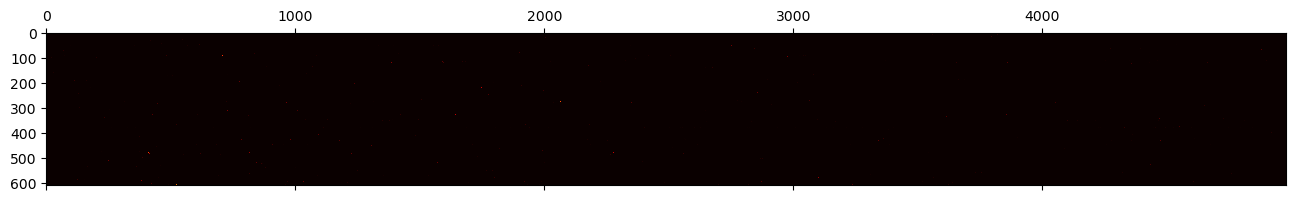

In [21]:
import ot.plot
import matplotlib.pyplot as plt

plt.matshow(otm, cmap='hot')
plt.show()


In [48]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from jm.SolveALS import Solve

solver_als = Solve(k=1, mu=0.02, alpha=0.0005, beta=0.0005, train_data=ratings_train, n_steps=50)
pred = solver_als.matrix_completion_als()
table = solver_als.predict_als()


In [38]:
np.unique(table, return_counts=True)


(array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5]),
 array([    82,  21311,  45800,  81588, 183963, 351834, 559256, 693809,
        590561, 325447, 126645,  39786,  11842,   3513,   1135,    508,
           300,    214,    122,     52,     22,      4,      4,      2]))

In [49]:
np.unique(np.around((solver_als.I_2@solver_als.U_2.T), 0))


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [47]:
(solver_als.I_2@solver_als.U_2.T).max()


11.469012321466183

In [39]:
compute_rmse(table, ratings_train)


0.7649909079913629